In [2]:
from matplotlib import pyplot as plt
from networkx.readwrite import json_graph
import seaborn as sns
import networkx as nx
import numpy as np
import pandas as pd
from glob import glob
from tqdm.notebook import tqdm
import json

MIN_PASSES_IN_POSSESSION = 4

# Read the data
filenames = glob('data/plays_filtered/*.json')
possessions = []
for filename in filenames:
    with open(filename, 'rb') as f:
        possessions_from_file = json.load(f)
    possessions.extend(possessions_from_file)

len(possessions)

# TODO: Get more data: report to Barry that his script isn't working for some games (e.g., 01.22.2016.OKC.at.DAL)

99

In [3]:
def draw_graph(G_attack: nx.Graph) -> None:
    # Draw the graph (must show node names and weights)
    pos = nx.spring_layout(G_attack)
    nx.draw(G_attack, pos, with_labels=True, connectionstyle='arc3,rad=0.1')
    
    edge_labels = nx.get_edge_attributes(G_attack, 'weight')
    nx.draw_networkx_edge_labels(G_attack, pos, edge_labels=edge_labels)

    plt.show()

In [4]:
# For each possession, create a directed graph from the passes in that possession.
# The nodes are the players, and the edges are the passes.
# The edge weight is the number of times that pass was made.

def compute_attacking_graph(possession):
    # Create the the attacking graph for this entire possession
    G_attack = nx.DiGraph()
    
    for pass_ in possession['Passes']:
        pass_from = pass_['pass_from'] or 'x'
        pass_to = pass_['pass_to'] or 'y'

        print(f'{pass_from} --> {pass_to}')

        # If this edge already exists, increase the weight by one, else add it
        if G_attack.has_edge(pass_from, pass_to):
            G_attack[pass_from][pass_to]['weight'] += 1
        else:
            G_attack.add_edge(pass_from, pass_to, weight=1)
    
    return G_attack


In [5]:
# Compute various metrics for the attacking graph

metric_labels_att = ['max_bwn_c', 'recip', 'triangles', 'numpasses']

def compute_metrics_on_attacking_graph(G_attack):
    results = pd.Series(index=metric_labels_att, dtype=float)
    results['max_bwn_c'] = max(nx.betweenness_centrality(G_attack).values())
    results['recip'] = nx.reciprocity(G_attack)
    results['triangles'] = sum(nx.triangles(nx.Graph(G_attack)).values()) // 3
    # sum of all edge weights
    results['numpasses'] = sum([G_attack[u][v]['weight'] for u, v in G_attack.edges()])
    
    return results

In [6]:
def compute_defending_team_for_possession(possession):
    #### Figure out which one is the defending team ####
    # Go through all the passes, see who made the pass, compute the team of this player, take the majority

    passee_team_for_each_pass = [] # "passee" = person who receives the pass
    
    for pass_ in possession['Passes']:
        
        snapshot = pass_['snapshots'][0]
        home_players = [player for player in snapshot['HomePlayers'].keys()]
        guest_players = [player for player in snapshot['GuestPlayers'].keys()]
        
        pass_to_team = None
        pass_to = pass_['pass_to']
        if pass_to in home_players:
            pass_to_team = 'home'
        elif pass_to in guest_players:
            pass_to_team = 'guest'
        else:
            pass_to_team = 'unknown'
        passee_team_for_each_pass.append(pass_to_team)
    
    defending_team = None

    # Sanity check: if this possession had equal-ish passees from both teams, then something is wrong
    passee_team_for_each_pass = pd.Series(passee_team_for_each_pass)
    num_home_passes = passee_team_for_each_pass.value_counts().get('home', 0)
    num_guest_passes = passee_team_for_each_pass.value_counts().get('guest', 0)
    if abs(num_home_passes - num_guest_passes) <= 2:
        defending_team = 'unknown'
    else:
        defending_team = passee_team_for_each_pass.value_counts().sort_values().index[0]

    return(defending_team)

In [7]:
def create_defensive_graphs_for_possession(possession):

    defending_team = compute_defending_team_for_possession(possession)
    if defending_team == 'unknown':
        return None

    # For each pass in the possession, get the defensive team's positions
    player_positions_key = 'HomePlayers' if defending_team == 'home' else 'GuestPlayers'
    defensive_graphs = []
    
    for pass_ in possession['Passes']:
        defending_team_positions = pass_['snapshots'][0][player_positions_key]
        ball_position = pass_['snapshots'][0]['Ball']

        # Create a graph with players as nodes and distance between them as edge lengths
        # Also add the ball as a node, and an edge between the ball and every player
        G = nx.Graph()
        G.add_node('ball')
        for player_name in defending_team_positions:
            G.add_node(player_name)
            # Add edge between this player and the ball
            player = defending_team_positions[player_name]
            distance = np.round(np.sqrt((player['x'] - ball_position['x'])**2 + (player['y'] - ball_position['y'])**2), 2)
            G.add_edge(player_name, 'ball', weight=distance)
        
        for player_name in defending_team_positions:
            player = defending_team_positions[player_name]
            for other_player_name in defending_team_positions:
                other_player = defending_team_positions[other_player_name]
                if player_name != other_player_name:
                    distance = np.round(np.sqrt((player['x'] - other_player['x'])**2 + (player['y'] - other_player['y'])**2), 2)
                    G.add_edge(player_name, other_player_name, weight=distance)
    
        # draw_graph(G)
        defensive_graphs.append(G)
    
    return defensive_graphs

In [8]:
# Compute various metrics for the defensive graph

metric_labels_def = ['max_pagerank', 'dist_from_ball', 'edge_sum'] # TODO: add more defensive metrics

def compute_metrics_on_defensive_graph(G_defense):
    results = pd.Series(index=metric_labels_def, dtype=float)
    results['max_pagerank'] = max(nx.pagerank(G_defense).values())
    results['dist_from_ball'] = sum([G_defense[u][v]['weight'] for u, v in G_defense.edges() if u == 'ball']) / (G_defense.number_of_nodes()-1)
    # sum of all edge weights
    results['edge_sum'] = sum([G_defense[u][v]['weight'] for u, v in G_defense.edges()])
    
    return results

In [9]:
# Create data for Jonathan

from networkx.readwrite import json_graph
import json

possessions_for_jonathan = []

for possession in tqdm(possessions):

    G_attack = compute_attacking_graph(possession)
    Gs_defense = create_defensive_graphs_for_possession(possession)
    if Gs_defense is None: # defending team is unknown
        continue
    
    possession['attacking_graph'] = json_graph.node_link_data(G_attack)
    possession['defensive_graphs'] = [json_graph.node_link_data(G_defense) for G_defense in Gs_defense]

    possessions_for_jonathan.append(possession)

with open('data/possessions_for_jonathan.json', 'w') as f:
    json.dump(possessions_for_jonathan, f)

  0%|          | 0/99 [00:00<?, ?it/s]

Arron Afflalo --> Jose Calderon
JJ Redick --> Jose Calderon
Jose Calderon --> Carmelo Anthony
Carmelo Anthony --> Jose Calderon
Jose Calderon --> Kristaps Porzingis
Arron Afflalo --> Jose Calderon
Kristaps Porzingis --> Arron Afflalo
JJ Redick --> Arron Afflalo
Arron Afflalo --> JJ Redick
JJ Redick --> Chris Paul
Chris Paul --> Kristaps Porzingis
Kristaps Porzingis --> Kristaps Porzingis
Luc Mbah a Moute --> Paul Pierce
Paul Pierce --> Kristaps Porzingis
Kristaps Porzingis --> Jose Calderon
Robin Lopez --> Jose Calderon
Jose Calderon --> Robin Lopez
Robin Lopez --> DeAndre Jordan
Chris Paul --> Robin Lopez
Paul Pierce --> Robin Lopez
Chris Paul --> Jose Calderon
Jose Calderon --> Chris Paul
JJ Redick --> Jose Calderon
Chris Paul --> Chris Paul
Jose Calderon --> Chris Paul
Chris Paul --> DeAndre Jordan
DeAndre Jordan --> Luc Mbah a Moute
Chris Paul --> DeAndre Jordan
DeAndre Jordan --> Chris Paul
Chris Paul --> Robin Lopez
Robin Lopez --> DeAndre Jordan
DeAndre Jordan --> Robin Lopez
Pa

In [10]:
# Try reading the data back in -- writing this function for Jonathan
def read_data_for_jonathan():
    with open('data/possessions_for_jonathan.json', 'r') as f:
        possessions_for_jonathan = json.load(f)
    
    for possession in possessions_for_jonathan:
        possession['attacking_graph'] = json_graph.node_link_graph(possession['attacking_graph'])
        possession['defensive_graphs'] = [json_graph.node_link_graph(G_defense) for G_defense in possession['defensive_graphs']]

    return possessions_for_jonathan

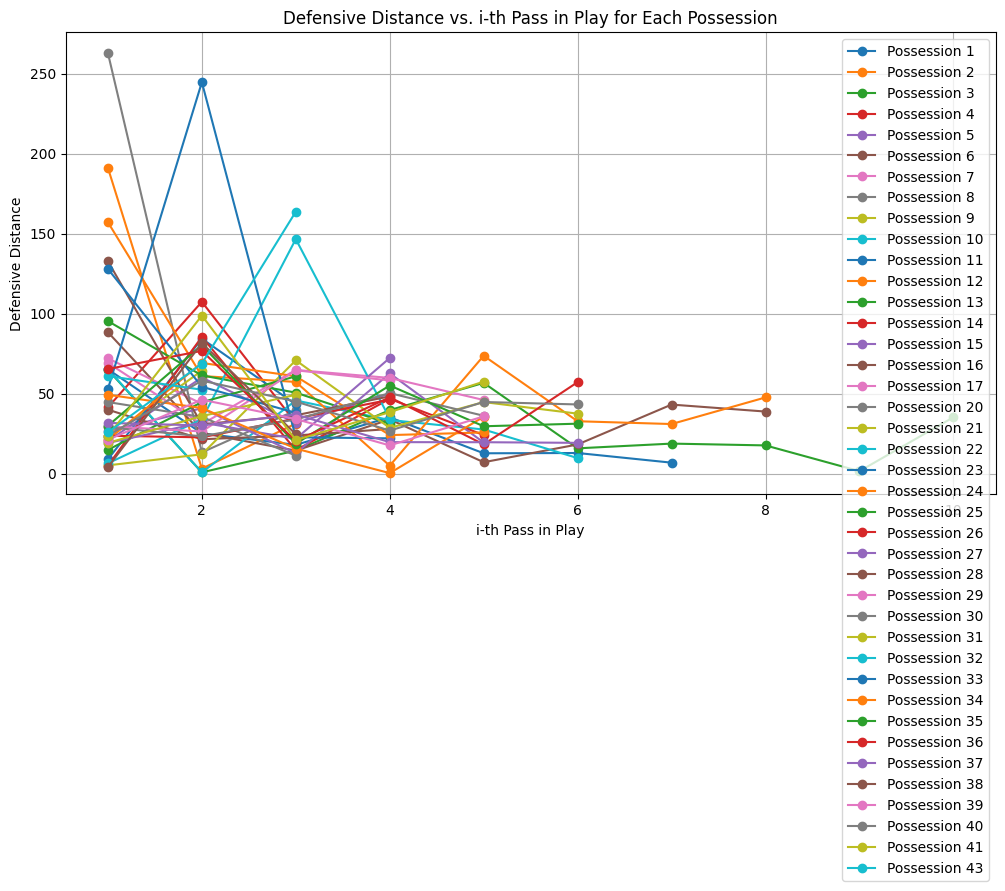

In [19]:
def create_defensive_distance_graph():
    possessions = read_data_for_jonathan()

    plt.figure(figsize=(12, 6))
    for i, possession in enumerate(possessions):
        if 'CombinedPasses' in possession:
            distances = [pass_['distance'] for pass_ in possession['CombinedPasses']]
            plt.plot(range(1, len(distances) + 1), distances, marker='o', label=f'Possession {i+1}')

    plt.xlabel('i-th Pass in Play')
    plt.ylabel('Defensive Distance')
    plt.title('Defensive Distance vs. i-th Pass in Play for Each Possession')
    plt.legend()
    plt.grid(True)
    plt.show()
create_defensive_distance_graph()

In [ ]:
rows = []
used_possessions = []

for possession in tqdm(possessions):
    # If there's too few passes in this possession, skip it
    if len(possession['Passes']) < MIN_PASSES_IN_POSSESSION:
        continue

    # TODO: add counter and see how much data we're filtering out
    # TODO: give defensive data to Jonathan

    G_attack = compute_attacking_graph(possession)
    # draw_graph(G_attack)

    Gs_defense = create_defensive_graphs_for_possession(possession)
    if Gs_defense is None: # defending team is unknown
        continue
    
    # Now we have both graphs, we can compute metrics for both
    
    # Compute metrics for attacking graph
    metrics_att = compute_metrics_on_attacking_graph(G_attack)
    metrics_def = []

    # With defensive graphs, it's complicated because there are multiple graphs.
    # We are guaranteed to have MIN_PASSES_IN_POSSESSION defensive graphs, so let's compute for just those.
    for G_defense in Gs_defense[:1]: # TODO: How many defensive graphs to use? If just one, which one?
        metrics_def_i = compute_metrics_on_defensive_graph(G_defense)
        metrics_def.append(metrics_def_i)
        # draw_graph(G_defense)
    
    metrics_def = pd.concat(metrics_def)
    row = pd.concat([metrics_att, metrics_def])
    # Add the label
    row['label'] = possession['Weight']
    rows.append(row)
    used_possessions.append(possession)
    

: 

In [ ]:
# TODO: The possession data need to be cleaned and/or manually validated. See the graphs below, some of them don't make sense.
#       1) Sometimes `pass_from` is None. What does that mean?
#       2) Sometimes, the defensive player appears in the attacking graph.
#          Is that okay or should we remove defensive players from the attacking graph?
#       3) In 5 games, there are only 85 filtered possessions with more than 4 passes? That seems wrong.

import random

i = random.randint(0, len(used_possessions))
poss = used_possessions[i]
a = compute_attacking_graph(poss)
d = create_defensive_graphs_for_possession(poss)

draw_graph(a)
draw_graph(d[0])

: 

In [ ]:
df = pd.DataFrame(rows)
df

: 

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Split the data into predictor variables (X) and label (y)
X = df.iloc[:, :len(metric_labels_att) + len(metric_labels_def)]
y = df['label']

# Split the data into training and testing sets with a 90-10 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Scale the data
# TODO: What is this doing?
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create the classification model
classification_model = LogisticRegression(multi_class='multinomial', solver='lbfgs')

# Fit the model to the training data
classification_model.fit(X_train_scaled, y_train)

# Predict the labels for the test data
y_pred = classification_model.predict(X_test_scaled)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
classification_report = classification_report(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{classification_report}")

# TODO: how to interpret this classification report?

: 

In [ ]:
# Get the coefficients
coefficients = classification_model.coef_

# Create a DataFrame for easy viewing
coeff_df = pd.DataFrame(coefficients, columns=X.columns)

# Transpose the DataFrame for easier viewing
coeff_df = coeff_df.T

# Add the class labels as column names
coeff_df.columns = classification_model.classes_

# Print the DataFrame
coeff_df

# TODO: How to interpret the coefficients?
# TODO: Are the features significant predictors?
# TODO: Should we try making this a binary classification problem?

: 

In [ ]:
import statsmodels.api as sm

# Add a constant to the features
X2 = sm.add_constant(X)

# Fit the model
model = sm.Logit(y, X2)
result = model.fit()

# Print the summary table
print(result.summary())

: 

Linear regression code below. Not using this anymore.

In [ ]:
# Create the regression model -- Not using this anymore
regression_model = LinearRegression()
regression_model.fit(X_train, y_train)
y_pred = regression_model.predict(X_test)

# The coefficients
print("Coefficients: \n", regression_model.coef_)

# The mean squared error
print(f"Mean squared error: {mean_squared_error(y_test, y_pred)}")
# The coefficient of determination: 1 is perfect prediction
print(f"Coefficient of determination: {r2_score(y_test, y_pred)}")


: 